In [11]:
import os
import pathlib
import numpy as np
import imageio
import glob
import matplotlib.pyplot as plt
import IPython.display
import PIL.Image
import imageio
import cv2

## Input Images Path

In [4]:
# Relative paths to the notebook
images_path = glob.glob("images/*.png")

output_path = 'outputs/'
# If output folder does not exist, create it
p = pathlib.Path(output_path)
if not p.is_dir():
    p.mkdir()

# Execute all dithering functions to all images
# NOTE: THE ENTIRE ACQUISITION TAKES ABOUT 5 MINUTES
execute_acquisitions = True

In [5]:
images_path

['images/objetos1.png', 'images/objetos3.png', 'images/objetos2.png']

In [6]:
images = {}
for img in images_path:
     images[os.path.split(img)[1]] = cv2.imread(img,-1)

## Color Transformation

### Gray

In [27]:
gray_images = {}

for key, img in images.items():
    gray_images[key] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

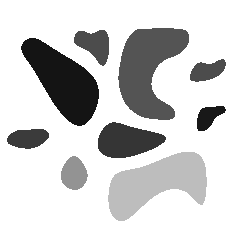

In [37]:
PIL.Image.fromarray(gray_images['objetos3.png'])

### Mono

In [38]:
mono_images = {}

for key, img in gray_images.items():
    mono_images[key] = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY)[1]

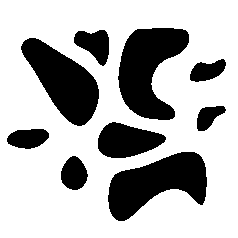

In [39]:
PIL.Image.fromarray(mono_images['objetos3.png'])

## Objects Contours

In [50]:
# In OpenCV, objects are white and the background is black, so we need to invert the image
# before finding the contours
contours = {}

for key, img in mono_images.items():
    # 255 - img is the inverse of img
    contours[key], _ = cv2.findContours(255 - img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [62]:
images_contours = {}

for key, img in mono_images.items():
    images_contours[key] = np.zeros_like(img) + 255
    cv2.drawContours(images_contours[key], contours[key], -1, (0), 2)

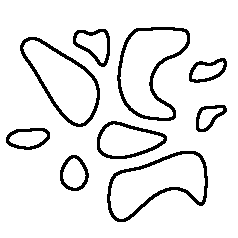

In [63]:
PIL.Image.fromarray(images_contours['objetos3.png'])